In [1]:
# Import Necessary Libraries
import pandas as pd
import numpy as np
import nltk
import joblib
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter

# Scikit-Learn Imports
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix

# NLTK Imports
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

# Download NLTK Resources
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

# Initialize Lemmatizer
lemmatizer = WordNetLemmatizer()

[nltk_data] Downloading package punkt to /home/gleitao/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/gleitao/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/gleitao/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
# Function to Lemmatize Text
def lemmatize_text(text):
    return ' '.join([lemmatizer.lemmatize(word) for word in text.split()])

# Function to Lowercase Text
def lower_text(text):
    return text.lower()

# Load Dataset Function
def load_data(filepath):
    data = pd.read_csv(filepath, sep='\t', names=['title', 'from', 'genre', 'director', 'plot'])
    return data

# Preprocess Data Function
def preprocess_data(data):
    # Extract relevant columns (title, director, plot, genre)
    data = data[['title', 'director', 'plot', 'genre']].copy()
    data.dropna(inplace=True)

    # Combine plot and director into a single feature (text)
    data['title_plot'] = data['title'] + ' ' + data['plot']
    data['title_plot'] = data['title_plot'].apply(lower_text)
    data['title_plot'] = data['title_plot'].apply(lemmatize_text)

    return data

# Load the dataset
dataset = load_data('train.txt')

# Preprocess the data
dataset = preprocess_data(dataset)

# Use CountVectorizer to get document-term matrix for stop words only
# Define the stop words (you can replace this with your custom stop words)
stop_words = set(stopwords.words('english'))  # Using NLTK's English stop words
vectorizer = CountVectorizer(vocabulary=stop_words, binary=True)  # 'binary=True' to count presence, not occurrences
X = vectorizer.fit_transform(dataset['title_plot'])  # Transform the text data

# Get the document frequencies for each stop word
doc_freq = X.sum(axis=0) / X.shape[0]  # Fraction of documents each word appears in

# Create a DataFrame with the stop word frequencies
stop_word_df = pd.DataFrame({
    'stop_word': vectorizer.get_feature_names_out(),
    'doc_frequency': doc_freq.A1  # Convert to a 1D array
})

# Set your threshold (e.g., words appearing in 80% or more of the documents)
threshold = 0.8
significant_stop_words = stop_word_df[stop_word_df['doc_frequency'] >= threshold]

# Display the significant stop words
print("Significant Stop Words:")
print(significant_stop_words)

Significant Stop Words:
    stop_word  doc_frequency
10        and       0.942793
65        his       0.835966
69         in       0.911081
71         is       0.891058
98         of       0.925631
129       the       0.977117
141        to       0.948638
164      with       0.818306


In [3]:
significant_stop_words["stop_word"].values

array(['and', 'his', 'in', 'is', 'of', 'the', 'to', 'with'], dtype=object)

***

In [4]:
dataset['genre'].value_counts()

genre
drama        1676
comedy       1193
horror       1108
action       1059
romance       886
western       829
crime         541
animation     535
sci-fi        214
Name: count, dtype: int64

In [5]:
def preprocess_data(data):
    # Extract relevant columns (title, plot, genre)
    data = data[['title', 'director', 'plot', 'genre']].copy()
    data.dropna(inplace=True)

    # Combine plot and director into a single feature (text)
    data['plot_director'] = data['plot'] + ' ' + data['director']
    
    # Combine plot and director into a single feature (text)
    data['title_director'] = data['title'] + ' ' + data['director']
    
    data['title_Word_Count'] = data['title'].apply(lambda x: len(x.split()))
    
    data['plot_Word_Count'] = data['plot'].apply(lambda x: len(x.split()))

    return data

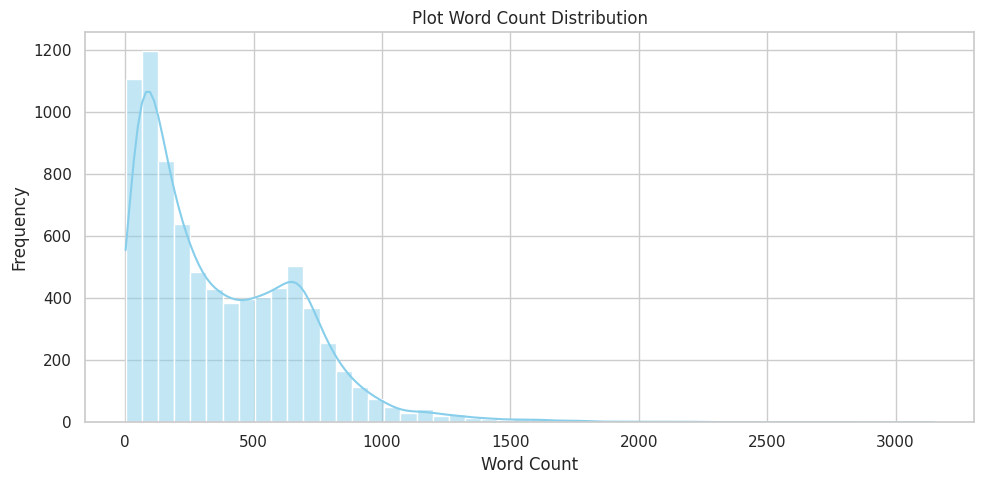

In [15]:
# Plotting the Lines Length Distribution and Characters Distribution
fig, ax = plt.subplots(figsize=(10, 5))

# Lines length distribution (by words)
sns.histplot(dataset['plot_Word_Count'], bins=50, ax=ax, kde=True, color='skyblue')
ax.set_title('Plot Word Count Distribution')
ax.set_xlabel('Word Count')
ax.set_ylabel('Frequency')

plt.tight_layout()
plt.show()

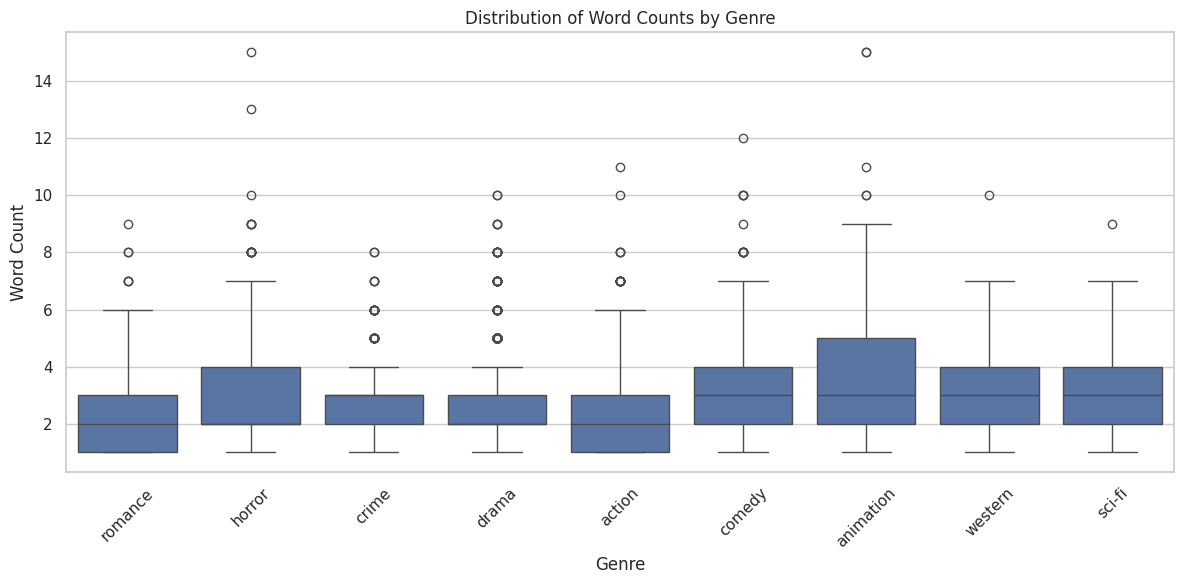

In [13]:
# Set the aesthetic style of the plots
sns.set(style="whitegrid")

# Create a box plot for word counts by genre
plt.figure(figsize=(12, 6))
sns.boxplot(x='genre', y='title_Word_Count', data=dataset)

# Set titles and labels
plt.title('Distribution of Word Counts by Genre')
plt.xlabel('Genre')
plt.ylabel('Word Count')
plt.xticks(rotation=45)  # Rotate x labels if needed
plt.tight_layout()
plt.show()

/tmp/ipykernel_5270/3911136407.py:14: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title='Genre', bbox_to_anchor=(1.05, 1), loc='upper left')  # Place legend outside the plot


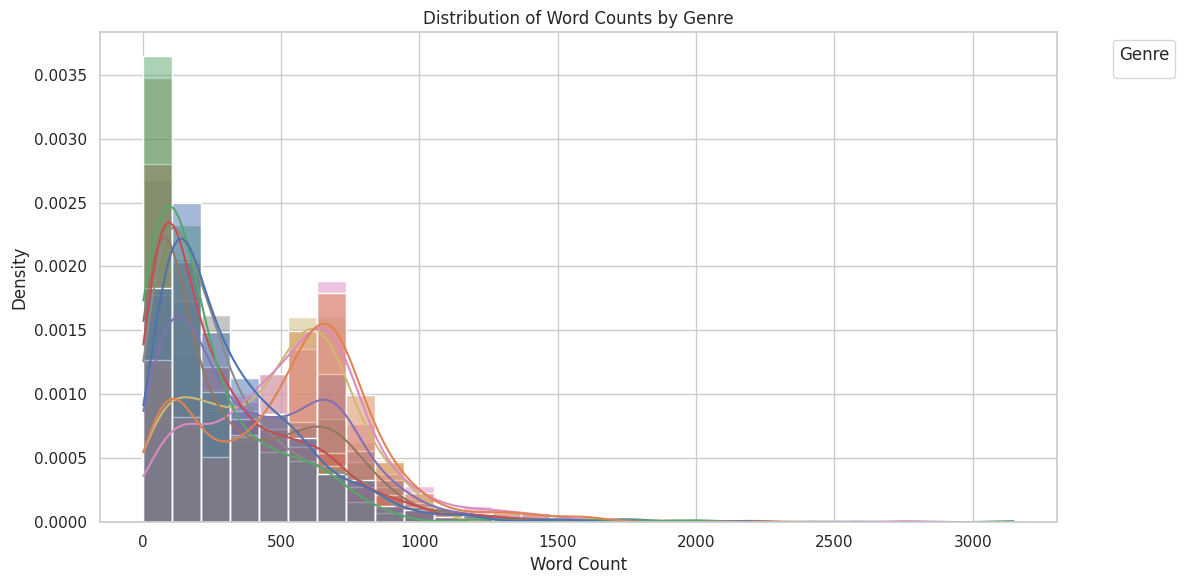

In [14]:
# Set the aesthetic style of the plots
sns.set(style="whitegrid")

# Create a histogram for word counts by genre
plt.figure(figsize=(12, 6))

# Plotting the histogram for each genre with a different color
sns.histplot(data=dataset, x='plot_Word_Count', hue='genre', bins=30, kde=True, stat='density', common_norm=False, alpha=0.5)

# Set titles and labels
plt.title('Distribution of Word Counts by Genre')
plt.xlabel('Word Count')
plt.ylabel('Density')
plt.legend(title='Genre', bbox_to_anchor=(1.05, 1), loc='upper left')  # Place legend outside the plot
plt.tight_layout()
plt.show()


In [18]:
for word in stop_words:
    # Usar str.count para contar as ocorrências da palavra em cada frase
    dataset[word] = dataset['plot'].str.lower().str.count(word)

/tmp/ipykernel_5270/3344486640.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  dataset[word] = dataset['plot'].str.lower().str.count(word)
/tmp/ipykernel_5270/3344486640.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  dataset[word] = dataset['plot'].str.lower().str.count(word)
/tmp/ipykernel_5270/3344486640.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) ins

In [100]:
metrics = {}
for word in stop_words:
    metrics[word] = {
        'sum': dataset[word].sum(),
        'mean': dataset[word].mean(),
        'maximum': dataset[word].max(),
        'std': dataset[word].std()
    }

# Criar um DataFrame a partir das métricas
metrics_df = pd.DataFrame(metrics).T
metrics_df.columns = ['sum', 'mean', 'max', 'std']

# Mostrar as métricas
print("\n metrics:")
print(metrics_df)



 metrics:
             sum      mean   max       std
couldn't    61.0  0.007586   2.0  0.089594
wouldn      52.0  0.006467   3.0  0.086144
why        474.0  0.058948   4.0  0.269987
those      370.0  0.046014   5.0  0.243056
needn        0.0  0.000000   0.0  0.000000
...          ...       ...   ...       ...
your       154.0  0.019152   8.0  0.182251
hers      3233.0  0.402064  18.0  0.963457
ours       810.0  0.100734   5.0  0.353801
which     6361.0  0.791071  23.0  1.355521
she's      322.0  0.040045   4.0  0.252624

[179 rows x 4 columns]


In [204]:
threshold = 1
filtered_metrics = metrics_df[metrics_df['mean'] > threshold]

# Mostrar as métricas filtradas
print(filtered_metrics['sum'].mean())

155961.5625


In [202]:
filtered_metrics

,sum,mean,max,std
with,32867.0,4.087427,40.0,4.023123
she,27217.0,3.384778,86.0,5.352401
not,12008.0,1.493347,27.0,2.050054
t,1182765.0,147.091780,1223.0,128.328202
up,19398.0,2.412387,39.0,3.056526
...,...,...,...,...
from,13817.0,1.718319,17.0,2.007665
off,9053.0,1.125855,25.0,1.716058
them,9570.0,1.190150,22.0,1.935793
own,12951.0,1.610621,36.0,2.234895


In [75]:
title_summary = preproc_dataset['title_Word_Count'].describe() # count, mean, std, ...
plot_summary = preproc_dataset['plot_Word_Count'].describe()

# Friends distribution
director_counts = dataset['director'].value_counts().sort_index()

# 45481 is the number of lines
print(f'''\n{'-'*60}
Title\n{title_summary}\n{'-'*60}
Plot\n{plot_summary}\n{'-'*60}
Plot\n{director_counts}\n{'-'*60}
''')

NameError: name 'preproc_dataset' is not defined

In [7]:
dataset['genre'].unique()

array(['romance', 'horror', 'crime', 'drama', 'action', 'comedy',
       'animation', 'western', 'sci-fi'], dtype=object)

In [13]:
df_results = pd.read_csv("results.txt", sep='\t')
df_results["genre"].unique()

array(['romance', 'action', 'animation', 'drama', 'comedy', 'western',
       'horror', 'crime', 'sci-fi'], dtype=object)

In [239]:
directors = dataset['director'].unique()
directors

array(['Ramana', 'Samuel Bayer', 'John Hough', ..., 'Burt Topper',
       'Tolga Karaçelik', 'Joyce Chopra'], dtype=object)